In [24]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import math

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

metop = 'MetOP_B'

In [25]:
removeData = [{'loc': [0, -140],
              'startDate': datetime(2009, 9, 1),
              'endDate':   datetime(2010, 4, 1)},
              
              {'loc': [2, -155],
              'startDate': datetime(2009, 5, 1),
              'endDate':   datetime(2010, 5, 1)},
              
              {'loc': [8, -180],
              'startDate': datetime(2009, 7, 1),
              'endDate':   datetime(2010, 3, 1)},
              
              {'loc': [0, -140],
              'startDate': datetime(2009, 9, 1),
              'endDate':   datetime(2010, 1, 1)}, 
              
              {'loc': [0, -155],
              'startDate': datetime(2010, 1, 1),
              'endDate':   datetime(2010, 9, 1)}, 
             
             {'loc': [2, 165],
              'startDate': datetime(2010, 2, 1),
              'endDate':   datetime(2010, 9, 1)}, 
             
             {'loc': [8, -180],
              'startDate': datetime(2015, 7, 1),
              'endDate':   datetime(2016, 5, 1)}]

remove_df = pd.DataFrame(removeData)

remove_df

,loc,startDate,endDate
0,"[0, -140]",2009-09-01,2010-04-01
1,"[2, -155]",2009-05-01,2010-05-01
2,"[8, -180]",2009-07-01,2010-03-01
3,"[0, -140]",2009-09-01,2010-01-01
4,"[0, -155]",2010-01-01,2010-09-01
5,"[2, 165]",2010-02-01,2010-09-01
6,"[8, -180]",2015-07-01,2016-05-01


In [26]:
ds= xr.open_dataset(f"/srv/data2/srai_poseidon/srai_poseidon/observation/SatelliteVsBuoy/downloads/Buoy/TAO_data/WINDS/{metop}/T_000N_165E_COARE3p5_2013_2020_2hrMeanVar_AS_Buoy_Glorys_Wave_Matchup.nc")
ds

<xarray.Dataset> Size: 1MB
Dimensions:            (AS_TIME: 1234, NUMCELLS: 3, HEIGHT: 3, DEPTH: 1)
Coordinates:
  * AS_TIME            (AS_TIME) datetime64[ns] 10kB 2014-10-29T22:04:30 ... ...
  * NUMCELLS           (NUMCELLS) int64 24B 0 1 2
  * HEIGHT             (HEIGHT) float32 12B 3.0 4.0 10.0
  * DEPTH              (DEPTH) float32 4B 1.0
Data variables: (12/83)
    wvc_index          (AS_TIME, NUMCELLS) float64 30kB ...
    model_speed        (AS_TIME, NUMCELLS) float64 30kB ...
    model_dir          (AS_TIME, NUMCELLS) float64 30kB ...
    ice_prob           (AS_TIME, NUMCELLS) float64 30kB ...
    ice_age            (AS_TIME, NUMCELLS) float64 30kB ...
    wvc_quality_flag   (AS_TIME, NUMCELLS) float64 30kB ...
    ...                 ...
    vo                 (AS_TIME) float64 10kB ...
    zos                (AS_TIME) float64 10kB ...
    uo                 (AS_TIME) float64 10kB ...
    thetao             (AS_TIME) float64 10kB ...
    so                 (AS_TIME) float64 10kB ...
    GLORYS_TIME        (AS_TIME) datetime64[ns] 10kB ...

In [27]:
flag_dict = {
    f'{meaning:41s}': bin(mask)[2:].zfill(23)
    for meaning, mask in zip(ds.wvc_quality_flag.flag_meanings.split(), ds.wvc_quality_flag.flag_masks)
}
flag_dict

{'distance_to_gmf_too_large                ': '00000000000000001000000',
 'data_are_redundant                       ': '00000000000000010000000',
 'no_meteorological_background_used        ': '00000000000000100000000',
 'rain_detected                            ': '00000000000001000000000',
 'rain_flag_not_usable                     ': '00000000000010000000000',
 'small_wind_less_than_or_equal_to_3_m_s   ': '00000000000100000000000',
 'large_wind_greater_than_30_m_s           ': '00000000001000000000000',
 'wind_inversion_not_successful            ': '00000000010000000000000',
 'some_portion_of_wvc_is_over_ice          ': '00000000100000000000000',
 'some_portion_of_wvc_is_over_land         ': '00000001000000000000000',
 'variational_quality_control_fails        ': '00000010000000000000000',
 'knmi_quality_control_fails               ': '00000100000000000000000',
 'product_monitoring_event_flag            ': '00001000000000000000000',
 'product_monitoring_not_used              ': '0001

In [28]:
def getSubDF(ds, LAT, LON):
    if [LAT, LON] in remove_df['loc'].tolist():
        print(f'MANUAL REMOVAL OF DATA IN LOC {LAT} {LON}')
        # Find index of matching location
        rindx = remove_df.index[remove_df['loc'].apply(lambda x: x == [LAT, LON])].tolist()[0]
        
        # Convert start and end dates to datetime64
        startDate = np.array(remove_df.loc[rindx, 'startDate'], dtype='datetime64[ns]')
        endDate = np.array(remove_df.loc[rindx, 'endDate'], dtype='datetime64[ns]')
        
        # Get time array from dataset
        dates = ds['AS_TIME'].to_numpy()
        
        # Create Boolean mask for time range
        mask = (dates >= startDate) & (dates < endDate)
        
        # Drop data within that time range
        ds = ds.sel(AS_TIME=~mask)

    LON = (LON+360)%360
        
    subds = xr.Dataset()

    taoTimeVar = ['TAO_TIME']
    
    windVars = ['WDIR',
         'WDIR_QC',
         'WDIR_DM',
         'WSPD',
         'WSPD_QC',
         'WSPD_DM',
         'UWND',
         'VWND']

    sstVars = ['SST',
             'SST_QC',
             'SST_DM']
    
    airtVars = ['AIRT',
             'AIRT_QC',
             'AIRT_DM']
    
    rhVars = ['RELH',
             'RELH_QC',
             'RELH_DM']
    
    u10Vars =['WSPD_10N',
             'WSPD_10']

    statVars= [f'mean_WSPD',
               f'std_WSPD',
               f'mean_WSPD_10N',
               f'std_WSPD_10N',
               f'mean_U10N_x',
               f'std_U10N_x',
               f'mean_U10N_y',
               f'std_U10N_y',
               f'mean_WDIR',
               f'std_WDIR',
               f'mean_cosWDIR',
               f'std_cosWDIR',
               f'mean_sinWDIR',
               f'std_sinWDIR',
               f'mean_SST',
               f'std_SST',
               f'mean_AIRT',
               f'std_AIRT',
               f'mean_SST - AIRT',
               f'std_SST - AIRT',
               f'mean_RELH',
               f'std_RELH',]
    
    
    satVars = ['wind_speed',
             'wind_dir',
             'wvc_quality_flag',
             'model_speed',
             'model_dir',
             'bs_distance',
             'dist_from_TAO_pos']

    waveVars = ['VHM0',
                 'VHM0_SW1',
                 'VHM0_SW2',
                 'VHM0_WW',
                 'VMDR',
                 'VMDR_SW1',
                 'VMDR_SW2',
                 'VMDR_WW',
                 'VPED',
                 'VSDX',
                 'VSDY',
                 'VTM01_SW1',
                 'VTM01_SW2',
                 'VTM01_WW',
                 'VTM02',
                 'VTM10',
                 'VTPK',
                 'WAVE_TIME']

    oceanVars = ['vo',
                 'zos',
                 'uo',
                 'thetao',
                 'so',
                 'GLORYS_TIME']
 
    
    for windVar in windVars:
        subds[windVar] = ds[windVar].sel(HEIGHT=4)
    subds.drop_vars('HEIGHT')
    for sstVar in sstVars:
        subds[sstVar] = ds[sstVar].sel(DEPTH=1)
    subds.drop_vars('DEPTH')
    for rhVar in rhVars:
        subds[rhVar] = ds[rhVar].sel(HEIGHT=3)
    subds.drop_vars('HEIGHT')
    for airtVar in airtVars:
        subds[airtVar] = ds[airtVar].sel(HEIGHT=3)
    subds.drop_vars('HEIGHT')
    for u10Var in u10Vars:
        subds[u10Var] = ds[u10Var].sel(HEIGHT=10)
    subds.drop_vars('HEIGHT')

    for var in waveVars:
        subds[var] = ds[var]

    for var in oceanVars:
        subds[var] = ds[var]

    for statVar in statVars:
        subds[statVar] = ds[statVar]

    subds['LATITUDE'] = xr.DataArray(LAT * np.ones(len(subds['AS_TIME']), dtype = float), dims=['AS_TIME'])
    subds['LONGITUDE'] = xr.DataArray(LON * np.ones(len(subds['AS_TIME']), dtype = float), dims=['AS_TIME'])
    
    subds['TAO_TIME'] = ds['TAO_TIME']

    deployFileName = f'../../../downloads/Buoy/TAO_data/WINDS/T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    ds2 = xr.open_dataset(deployFileName)
    startDates = np.array(ds2['startDate'])
    endDates = np.array(ds2['endDate'])

    depNum = np.zeros((len(subds['AS_TIME'])), dtype=int)
    c = 1
    for i in range(1,len(startDates)):
        mask = subds['AS_TIME'] >= startDates[i]
        mask *= subds['AS_TIME'] <= endDates[i]
        depNum[mask] = c
        c = c+1

    subds['Deployment index'] = xr.DataArray(depNum, dims=['AS_TIME'])
    
    
    satDS = ds[satVars]
    satDS = satDS.isel(NUMCELLS=0)    
    
    returnDS = xr.merge((subds, satDS))

    
    
    return returnDS

In [29]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)


allDS = xr.Dataset()
dataCount = 0
fileCount = 0
for task in taskList:
    lat = task[0]
    lon = task[1]

    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
    else:
        lonUnits = 'E'

    #LON = (LON+360)%360
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../../downloads/Buoy/TAO_data/WINDS/{metop}/T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}_COARE3p5_2013_2020_2hrMeanVar_AS_Buoy_Glorys_Wave_Matchup.nc'
    #deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        print(f'T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc')
        rds = xr.open_dataset(matchFname)
        ds = getSubDF(rds, LAT, LON)
        AS_TIME = ds['AS_TIME'].to_numpy()
        ds = ds.rename({'AS_TIME':'count'})
        dataLen = len(ds['count'])
        print(dataCount, dataCount+dataLen)
        ds['count'] = xr.DataArray(pd.Series(np.arange(dataCount, dataCount+dataLen)), 
                                   dims = ['count'])
        ds['AS_TIME'] = xr.DataArray(AS_TIME, 
                                   dims = ['count'])
        dataCount += dataLen
        if fileCount == 0:
            allDS = ds
        else:
            allDS = xr.concat((allDS, ds), dim='count')
        fileCount += 1
        

T_008S_095W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
0 509
T_008S_110W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
509 1557
T_008S_125W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
1557 2808
T_008S_155W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
2808 3483
T_008S_170W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
3483 4017
T_008S_180W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
4017 4534
T_008S_165E_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
4534 4973
T_005S_095W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
4973 5802
T_005S_110W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
5802 7149
T_005S_125W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
7149 8107
T_005S_140W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
8107 9211
T_005S_155W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
9211 9786
T_005S_170W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
9786 10408
T_005S_180W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
10408 11020
T_005S_165E_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
11020 11118
T_002S_095

In [30]:
allDS

<xarray.Dataset> Size: 21MB
Dimensions:            (count: 37990)
Coordinates:
  * count              (count) int64 304kB 0 1 2 3 4 ... 37986 37987 37988 37989
    HEIGHT             float32 4B 4.0
    DEPTH              float32 4B 1.0
    NUMCELLS           int64 8B 0
Data variables: (12/77)
    WDIR               (count) float32 152kB 120.0 130.0 110.0 ... 226.0 199.0
    WDIR_QC            (count) float32 152kB 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0
    WDIR_DM            (count) |S1 38kB b'D' b'D' b'D' b'D' ... b'D' b'D' b'D'
    WSPD               (count) float32 152kB 6.65 6.93 5.07 ... 2.68 7.46 8.54
    WSPD_QC            (count) float32 152kB 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0
    WSPD_DM            (count) |S1 38kB b'D' b'D' b'D' b'D' ... b'D' b'D' b'D'
    ...                 ...
    wvc_quality_flag   (count) float64 304kB 0.0 0.0 0.0 ... 2.048e+03 0.0 0.0
    model_speed        (count) float64 304kB 6.03 6.75 5.5 ... 3.09 6.11 9.33
    model_dir          (count) float64 304kB 316.2 297.5 321.0 ... 253.2 250.7
    bs_distance        (count) float64 304kB 0.2 0.0 0.5 0.0 ... 0.1 0.1 -1.2
    dist_from_TAO_pos  (count) float64 304kB 10.74 11.18 11.44 ... 12.62 12.56
    AS_TIME            (count) datetime64[ns] 304kB 2014-03-28T03:27:07 ... 2...

In [31]:
allDS = allDS.drop_vars(['HEIGHT','DEPTH','NUMCELLS'])

In [32]:
allDS

<xarray.Dataset> Size: 21MB
Dimensions:            (count: 37990)
Coordinates:
  * count              (count) int64 304kB 0 1 2 3 4 ... 37986 37987 37988 37989
Data variables: (12/77)
    WDIR               (count) float32 152kB 120.0 130.0 110.0 ... 226.0 199.0
    WDIR_QC            (count) float32 152kB 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0
    WDIR_DM            (count) |S1 38kB b'D' b'D' b'D' b'D' ... b'D' b'D' b'D'
    WSPD               (count) float32 152kB 6.65 6.93 5.07 ... 2.68 7.46 8.54
    WSPD_QC            (count) float32 152kB 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0
    WSPD_DM            (count) |S1 38kB b'D' b'D' b'D' b'D' ... b'D' b'D' b'D'
    ...                 ...
    wvc_quality_flag   (count) float64 304kB 0.0 0.0 0.0 ... 2.048e+03 0.0 0.0
    model_speed        (count) float64 304kB 6.03 6.75 5.5 ... 3.09 6.11 9.33
    model_dir          (count) float64 304kB 316.2 297.5 321.0 ... 253.2 250.7
    bs_distance        (count) float64 304kB 0.2 0.0 0.5 0.0 ... 0.1 0.1 -1.2
    dist_from_TAO_pos  (count) float64 304kB 10.74 11.18 11.44 ... 12.62 12.56
    AS_TIME            (count) datetime64[ns] 304kB 2014-03-28T03:27:07 ... 2...

In [33]:
flag_dict = {
    f'{meaning:41s}': bin(mask)[2:].zfill(23)
    for meaning, mask in zip(ds.wvc_quality_flag.flag_meanings.split(), ds.wvc_quality_flag.flag_masks)
}
flag_dict

{'distance_to_gmf_too_large                ': '00000000000000001000000',
 'data_are_redundant                       ': '00000000000000010000000',
 'no_meteorological_background_used        ': '00000000000000100000000',
 'rain_detected                            ': '00000000000001000000000',
 'rain_flag_not_usable                     ': '00000000000010000000000',
 'small_wind_less_than_or_equal_to_3_m_s   ': '00000000000100000000000',
 'large_wind_greater_than_30_m_s           ': '00000000001000000000000',
 'wind_inversion_not_successful            ': '00000000010000000000000',
 'some_portion_of_wvc_is_over_ice          ': '00000000100000000000000',
 'some_portion_of_wvc_is_over_land         ': '00000001000000000000000',
 'variational_quality_control_fails        ': '00000010000000000000000',
 'knmi_quality_control_fails               ': '00000100000000000000000',
 'product_monitoring_event_flag            ': '00001000000000000000000',
 'product_monitoring_not_used              ': '0001

In [34]:
flags = np.array(allDS['wvc_quality_flag'].to_numpy(), dtype=int)
eflags = np.array(['{:023b}'.format(val) for val in flags])

rain_detected = np.array([val[3] == '1' for val in eflags])
beam_noise_content_above_threshold = np.array([val[14] == '1' for val in eflags])
not_enough_good_sigma0_for_wind_retrieval = np.array([val[16] == '1' for val in eflags])

rainMask = np.logical_or(rain_detected, beam_noise_content_above_threshold)
rainMask = np.logical_or(rainMask, not_enough_good_sigma0_for_wind_retrieval)


In [35]:
noRainMask = ~rainMask
mask1 = allDS['WSPD_QC'].isin([1,2]).to_numpy()
mask2 = allDS['WDIR_QC'].isin([1,2]).to_numpy()
mask3 = allDS['SST_QC'].isin([1,2]).to_numpy()
mask4 = allDS['RELH_QC'].isin([1,2]).to_numpy()
mask5 = allDS['AIRT_QC'].isin([1,2]).to_numpy()

In [36]:
selectMask = np.logical_and(noRainMask, mask1)
selectMask = np.logical_and(selectMask, mask2)
selectMask = np.logical_and(selectMask, mask3)
selectMask = np.logical_and(selectMask, mask4)
selectMask = np.logical_and(selectMask, mask5)

In [37]:
for var in ['WSPD', 'WDIR', 'SST', 'RELH', 'AIRT',
           'mean_WSPD', 'mean_WDIR', 'mean_SST', 'mean_RELH', 'mean_AIRT', 'mean_SST - AIRT',
           'std_WSPD', 'std_WDIR', 'std_SST', 'std_RELH', 'std_AIRT', 'std_SST - AIRT',
           'mean_U10N_x', 'mean_U10N_y',
           'std_U10N_x', 'std_U10N_y',
           'std_cosWDIR', 'std_sinWDIR',
            'wind_speed', 'wind_dir']:
    selectMask = np.logical_and(selectMask, ~np.isnan(allDS[var].to_numpy()))

In [38]:
indices = selectMask.nonzero()[0]

In [39]:
goodDataSet = allDS.sel(count=indices)

In [40]:
goodDataSet = goodDataSet.rename_vars({'WSPD':'WSPD (TAO)',
                                          'WDIR':'WDIR (TAO)',
                                          'UWND': 'UWND (TAO)',
                                          'VWND': 'VWND (TAO)',
                                          'SST': 'SST (TAO)',
                                          'RELH': 'RELH (TAO)',
                                          'AIRT': 'AIRT (TAO)',
                                          'WSPD_10N': 'WSPD_10N (TAO)',
                                          'WSPD_10': 'WSPD_10 (TAO)',
                                          'wind_speed': 'WSPD_10N (ASCAT)',
                                          'wind_dir': 'WDIR (ASCAT)', 
                                          'mean_U10N_x': 'mean_UWND_10N', 
                                          'mean_U10N_y': 'mean_VWND_10N',
                                          'std_U10N_x': 'std_UWND_10N', 
                                          'std_U10N_y': 'std_VWND_10N',})

In [41]:
#goodDataSet.to_netcdf(f'goodData_ASwithTAO_{metop}.nc')

In [42]:
print(len(goodDataSet['count']))

35508


In [43]:
df = goodDataSet.copy()

In [44]:
df['WSPD_DIFF (ASCAT - TAO)'] = df['WSPD_10N (ASCAT)'] - df['WSPD_10N (TAO)']

## change true degrees to degrees where 0 deg mean_east and 90 deg mean_north 
#df['WDIR (TAO)'] = (-(df['WDIR (TAO)'] - 90.0) + 360)%360
df['WDIR (ASCAT)'] = (-(df['WDIR (ASCAT)'] - 90.0) + 360)%360

## calculate zonal and meridional winds 
df['UWND_10N (TAO)'] = df['WSPD_10N (TAO)'] * np.cos(np.deg2rad(df['WDIR (TAO)']))
df['VWND_10N (TAO)'] = df['WSPD_10N (TAO)'] * np.sin(np.deg2rad(df['WDIR (TAO)']))

df['UWND_10N (ASCAT)'] = df['WSPD_10N (ASCAT)'] * np.cos(np.deg2rad(df['WDIR (ASCAT)']))
df['VWND_10N (ASCAT)'] = df['WSPD_10N (ASCAT)'] * np.sin(np.deg2rad(df['WDIR (ASCAT)']))

#### Speed and direction QS corrected to absolute using GLORYS
df['UWND_10N (ASCAT) absolute'] = df['UWND_10N (ASCAT)'] + df['uo']
df['VWND_10N (ASCAT) absolute'] = df['VWND_10N (ASCAT)'] + df['vo']

absolute_direction_QS = np.rad2deg(np.arctan2(df['VWND_10N (ASCAT) absolute'],
                                              df['UWND_10N (ASCAT) absolute']))

absolute_direction_QS = (absolute_direction_QS+360)%360

df['WDIR (ASCAT) absolute'] = absolute_direction_QS

## direction diff in range (-180,180)
dirDiff = ((df['WDIR (ASCAT)'] - df['WDIR (TAO)'])+360)%360
dirDiff = xr.where(dirDiff > 180, dirDiff-360, dirDiff)
df['WDIR_DIFF (ASCAT - TAO)'] = dirDiff
df['cos(WDIR_DIFF (ASCAT - TAO))'] = np.cos(np.deg2rad(dirDiff))
df['sin(WDIR_DIFF (ASCAT - TAO))'] = np.sin(np.deg2rad(dirDiff))

df['UWND_DIFF (ASCAT - TAO)'] = df['UWND_10N (ASCAT)'] - df['UWND_10N (TAO)']
df['VWND_DIFF (ASCAT - TAO)'] = df['VWND_10N (ASCAT)'] - df['VWND_10N (TAO)']

## direction diff in range (-180,180) with absolute
dirDiff = ((df['WDIR (ASCAT) absolute'] - df['WDIR (TAO)'])+360)%360
dirDiff = xr.where(dirDiff > 180, dirDiff-360, dirDiff)
df['WDIR_DIFF (ASCAT - TAO) absolute'] = dirDiff
df['cos(WDIR_DIFF (ASCAT - TAO)) absolute'] = np.cos(np.deg2rad(dirDiff))
df['sin(WDIR_DIFF (ASCAT - TAO)) absolute'] = np.sin(np.deg2rad(dirDiff))

df['UWND_DIFF (ASCAT - TAO) absolute'] = df['UWND_10N (ASCAT) absolute'] - df['UWND_10N (TAO)']

df['VWND_DIFF (ASCAT - TAO) absolute'] = df['VWND_10N (ASCAT) absolute'] - df['VWND_10N (TAO)']


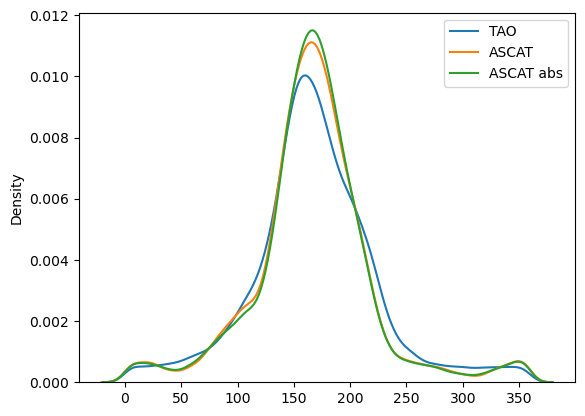

In [45]:
sns.kdeplot(df['WDIR (TAO)'], label = 'TAO',)
sns.kdeplot(df['WDIR (ASCAT)'], label = 'ASCAT')
sns.kdeplot(df['WDIR (ASCAT) absolute'], label = 'ASCAT abs')
plt.legend()

In [46]:
df.to_netcdf(f'rainFlagRemovedBuoyDataBadQualityRemovedMatchup_{metop}_waveAndGlorysAdded_manualRemove.nc')

In [47]:
dsA = xr.open_dataset(f'rainFlagRemovedBuoyDataBadQualityRemovedMatchup_MetOP_A_waveAndGlorysAdded_manualRemove.nc')
dsB = xr.open_dataset(f'rainFlagRemovedBuoyDataBadQualityRemovedMatchup_MetOP_B_waveAndGlorysAdded_manualRemove.nc')
dsB['count'] = dsB['count'] + np.max(dsA['count'].to_numpy()) + 1

ds = xr.concat([dsA, dsB], dim='count')
ds.to_netcdf(f'rainFlagRemovedBuoyDataBadQualityRemovedMatchup_MetOP_AB_waveAndGlorysAdded_manualRemove.nc')